In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Google Collab
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_ratings.csv')
# df = df[['Username','BGGId','Rating']]
# game_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/games.csv')

In [2]:
## Local pc
df = pd.read_csv('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/data/user_ratings.csv')
df = df[['Username','BGGId','Rating']]
game_df = pd.read_csv('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/data/games.csv')

In [3]:
# Ensure all datapoints are the same type
df['Username'] = df['Username'].astype(str)
df['BGGId'] = df['BGGId'].astype(int)
df['Rating'] = df['Rating'].astype('float32')

In [4]:
def recent_game(date):
    """ 
    Transform the PublishedYear Column to a binary classification. If it was before 2016, it is old(0), otherwise new(1)
    
    Parameters:
        date(int): the date publication    

    Returns:
        0 or 1 depending on the date provided. 
    """
    if date > 2016:
        return 1
    else: 
        return 0
    
game_df['new_or_old'] = game_df['YearPublished'].apply(recent_game)

In [5]:
# Encode the BGGId and Username to a certain value via a dictionary
user_ids = df['Username'].unique().tolist()
game_ids = df['BGGId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
game2game_encoded = {x: i for i,x in enumerate(game_ids)}

In [9]:
def df_with_features(df1, df2):
    """
        Creates a dataframe with the necessary features (Username, BGGId, Rating, user, game, new_or_old, BayesAvgRating, BestPlayers, MfgPlaytime, NumUserRatings) for predictions

        Parameters:
            df1: Dataframe with features: YearPublished, BayesAvgRating, BestPlayers, MfgPlaytime, NumUserRatings
            df2: Dataframe with features: Username, BGGId, Rating

        Returns:
            A combined dataframe with the features: Username, BGGId, Rating, user, game, new_or_old, BayesAvgRating, BestPlayers, MfgPlaytime, NumUserRatings

    """

    feats = ['BGGId','new_or_old','BayesAvgRating','BestPlayers','MfgPlaytime','NumUserRatings']
    feats_df = df1[feats]
    combined_features_df = feats_df.merge(df2, on='BGGId')
    combined_features_df['user_encode'] = combined_features_df['Username'].map(user2user_encoded)
    combined_features_df['bggid_encode'] = combined_features_df['BGGId'].map(game2game_encoded)
    return combined_features_df

In [10]:
combined_features_df = df_with_features(game_df, df)
combined_features_df

,BGGId,new_or_old,BayesAvgRating,BestPlayers,MfgPlaytime,NumUserRatings,Username,Rating,user_encode,bggid_encode
0,1,0,7.10363,5,240,5354,ArashDaemon666,4.0,153134,10669
1,1,0,7.10363,5,240,5354,SWxNW,4.0,120151,10669
2,1,0,7.10363,5,240,5354,Dr_Dog,4.0,153385,10669
3,1,0,7.10363,5,240,5354,zantos,4.0,141658,10669
4,1,0,7.10363,5,240,5354,kittykat27,4.0,71882,10669
...,...,...,...,...,...,...,...,...,...,...
18942210,349161,0,5.50806,0,45,70,Charly_,10.0,380770,13924
18942211,349161,0,5.50806,0,45,70,MissMeepleDesign_FR,9.0,380771,13924
18942212,349161,0,5.50806,0,45,70,greggyBSW,9.0,8419,13924
18942213,349161,0,5.50806,0,45,70,motts,8.0,62968,13924


In [ ]:
feats = ['new_or_old','BayesAvgRating','BestPlayers','MfgPlaytime','NumUserRatings']
feats_to_scale = ['BayesAvgRating','MfgPlaytime','NumUserRatings']

In [9]:
# Create train and test sets that are scaled
X = combined_features_df[['user_encode','bggid_encode','new_or_old','BayesAvgRating','BestPlayers','MfgPlaytime','NumUserRatings']]
y = combined_features_df[['Rating']]
scaler = MinMaxScaler()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
y_train, y_test = scaler.fit_transform(y_train), scaler.transform(y_test)
x_train[feats_to_scale], x_test[feats_to_scale] = scaler.fit_transform(x_train[feats_to_scale]), scaler.transform(x_test[feats_to_scale])

In [10]:
# Hybrid Model
embed_size = 50
num_users = len(user2user_encoded)
num_games = len(game2game_encoded)
num_feats = len(feats)

#input layer
user_in = Input(name='user_in', shape=(1,))
prod_in = Input(name='prod_in', shape=(1,))

#matrix factorization
mf_user_emb = Embedding(name='mf_user_emb', input_dim=num_users, output_dim = embed_size)(user_in)
mf_user_flat = Flatten(name='mf_user_flat')(mf_user_emb)
mf_prod_emb = Embedding(name='mf_prod_emb', input_dim=num_games, output_dim=embed_size)(prod_in)
mf_prod_flat = Flatten(name='mf_prod_flat')(mf_prod_emb)
mf_dot = Dot(name='mf_dot', normalize=True, axes=1)([mf_user_flat, mf_prod_flat])

#neural network
nn_user_emb = Embedding(name='nn_user_emb', input_dim = num_users, output_dim = embed_size)(user_in)
nn_user_flat = Flatten(name='nn_user_flat')(nn_user_emb)
nn_prod_emb = Embedding(name='nn_prod_emb', input_dim=num_games, output_dim= embed_size)(prod_in)
nn_prod_flat = Flatten(name='nn_prod_flat')(nn_prod_emb)
nn_concat = Concatenate()([nn_user_flat, nn_prod_flat])
nn_dense = Dense(name='nn_dense', units=int(embed_size/2), activation='relu')(nn_concat)

# Product features
feats_in = Input(name='feat_in', shape=(num_feats,))
feats_dense = Dense(name='feat_dense', units = num_feats, activation = 'relu')(feats_in)

#Merge both together
combo = Concatenate()([mf_dot, nn_dense, feats_dense])
y_out = Dense(name='y_out', units=1, activation='linear')(combo)

hyb_model = Model(inputs=[user_in, prod_in, feats_in], outputs = y_out, name='hybrid_model')
hyb_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
hyb_model.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_in (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 prod_in (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 nn_user_emb (Embedding)        (None, 1, 50)        20568750    ['user_in[0][0]']                
                                                                                                  
 nn_prod_emb (Embedding)        (None, 1, 50)        1096250     ['prod_in[0][0]']                
                                                                                       

In [11]:
history = hyb_model.fit(x=[x_train['user'], x_train['game'], x_train[feats]], y=y_train, epochs=50, batch_size = 5000, verbose=True)

Epoch 1/50
3031/3031 [==============================] - 121s 37ms/step - loss: 0.0472 - mean_squared_error: 0.0472
Epoch 2/50
3031/3031 [==============================] - 52s 17ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 3/50
3031/3031 [==============================] - 52s 17ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 4/50
3031/3031 [==============================] - 49s 16ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 5/50
3031/3031 [==============================] - 49s 16ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 6/50
3031/3031 [==============================] - 48s 16ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 7/50
3031/3031 [==============================] - 47s 16ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 8/50
3031/3031 [==============================] - 49s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 9/50
3031/3031 [==============================] - 47s 16ms/step - loss: 0.0062 - 

Text(0.5, 0, 'epoch')

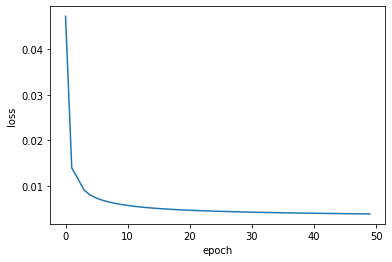

In [12]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

In [13]:
## Google colab
# hyb_model.save('/content/drive/MyDrive/Colab Notebooks/hybrid_model')

In [14]:
## Local PC
# hyb_model.save('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/hybrid_model')

In [ ]:
# y_pred = hyb_model.predict(x=[x_test['user'], x_test['game'],x_test[feats]])

In [ ]:
# mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
# saved_model = tf.keras.models.load_model('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/hybrid_model')/

In [14]:
def user_recommendations(user, n_games,model):
    """
        Takes in a user, n_games and a model to returns their top n_games recommendations that they have not rated yet.

        Parameters:
            user(str): name of user
            n_games(int): number of games to show
            model: the model to use for predictions
            
        Returns:
            A list with each game as an index with a column for their estimated rating
    """
    # Remove the boardgames that the user have rated
    boardgame_ids = combined_features_df['BGGId'].unique()
    user_game_list = combined_features_df.loc[combined_features_df['Username']==user, 'BGGId']
    user_game_list = np.setdiff1d(boardgame_ids, user_game_list)

    # Create dataframe of unique games for the user and a dataframe of the boardgames features
    testset = [[user, bggid] for bggid in user_game_list]
    testset = pd.DataFrame(testset, columns=['Username','BGGId'])
    feats = ['BGGId','new_or_old','BayesAvgRating','BestPlayers','MfgPlaytime','NumUserRatings']
    feat_df = game_df[game_df['BGGId'].isin(user_game_list)][feats]
    # Combine the two dataframes to be used in prediction model
    testset = df_with_features(feat_df, testset)
    feats = ['new_or_old','BayesAvgRating','BestPlayers','MfgPlaytime','NumUserRatings']
    feats_to_scale = ['BayesAvgRating','MfgPlaytime','NumUserRatings']

    # Get training data and scale it to apply to the testset
    scaler = MinMaxScaler()
    X = combined_features_df[['user_encode','bggid_encode','new_or_old','BayesAvgRating','BestPlayers','MfgPlaytime','NumUserRatings']]
    y = combined_features_df[['Rating']]
    x_train, _, _, _ = train_test_split(X,y,test_size=0.2, random_state=0)
    x_train[feats_to_scale] = scaler.fit_transform(x_train[feats_to_scale])
    testset[feats_to_scale] = scaler.transform(testset[feats_to_scale])

    # Test model on the testset and determine the boardgames with the highest rating
    predictions = model.predict(x=[testset['user_encode'],testset['bggid_encode'],testset[feats]])
    # Reshaped the predictions array by Transposing it. 
    top_ratings_idx = predictions.T[0].argsort()[::-1][:n_games]
    bgg_ids = user_game_list[top_ratings_idx]
    bgg_name = [game_df.loc[game_df['BGGId'] ==id]['Name'].values[0] for id in bgg_ids]
    print(f'Top boardgames for {user} in order are: \n {bgg_name}')

In [15]:
user_recommendations('bennygui', 5, hyb_model)

673/673 [==============================] - 2s 2ms/step
Top boardgames for bennygui in order are: 
 ['The Badger Deck', 'Dominion Einsteiger-Bigbox', 'Pentaurus: Duel', 'Oathsworn: Into the Deepwood', 'Tiny Epic Galaxies BLAST OFF!']
